##### Problem Statement

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

The task is to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.


##### Objective

- To predict whether a liability customer will buy a personal loan or not.
- Which variables are most significant.
- Which segment of customers should be targeted more.

In [84]:
# Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from utils import histogram_boxplot, labeled_barplot

# split to train and test
from sklearn.model_selection import train_test_split

# for Logistic regression
from sklearn.linear_model import LogisticRegression

# for scaling
from sklearn.preprocessing import MinMaxScaler

# metric
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             f1_score,
                             accuracy_score,
                             precision_recall_curve,
                             roc_auc_score,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             roc_curve)

# imbalance data
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# for decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# cross validation
from sklearn.model_selection import cross_val_score

# import the grid search model and the estimator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


##### Loading the data

In [2]:
path = r'./Loan_Modelling.csv'

In [3]:
data = pd.read_csv(path)

data.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


##### Columns Information
* ID: Customer ID
* Age: Customer’s age in completed years
* Experience: #years of professional experience
* Income: Annual income of the customer (in thousand dollars)
* ZIP Code: Home Address ZIP code.
* Family: the Family size of the customer
* CCAvg: Average spending on credit cards per month (in thousand dollars)
* Education: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* Mortgage: Value of house mortgage if any. (in thousand dollars)
* Personal_Loan: Did this customer accept the personal loan offered in the last campaign?
* Securities_Account: Does the customer have securities account with the bank?
* CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?
* Online: Do customers use internet banking facilities?
* CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?



In [4]:
# make copy of the data
df = data.copy() 

##### Data Exploration & Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [6]:
# checking sum of null values
df.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

In [7]:
# unique value of age
df.Age.unique()

array([25, 45, 39, 35, 37, 53, 50, 34, 65, 29, 48, 59, 67, 60, 38, 42, 46,
       55, 56, 57, 44, 36, 43, 40, 30, 31, 51, 32, 61, 41, 28, 49, 47, 62,
       58, 54, 33, 27, 66, 24, 52, 26, 64, 63, 23], dtype=int64)

In [8]:
# unique value of Experience
df.Experience.unique()

array([ 1, 19, 15,  9,  8, 13, 27, 24, 10, 39,  5, 23, 32, 41, 30, 14, 18,
       21, 28, 31, 11, 16, 20, 35,  6, 25,  7, 12, 26, 37, 17,  2, 36, 29,
        3, 22, -1, 34,  0, 38, 40, 33,  4, -2, 42, -3, 43], dtype=int64)

From the unique values of experience I observed negative values {-1,-2,-3}

In [9]:
negative_exp = df[df.Experience<0]
# check the value counts of each negative experience
negative_exp.Experience.value_counts()

-1    33
-2    15
-3     4
Name: Experience, dtype: int64

In [10]:
print(f'The total number of individuals with negative experience are {len(negative_exp)}')

The total number of individuals with negative experience are 52


In [11]:
negative_exp.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,52.0,2427.346154,1478.834118,90.0,767.25,2783.5,3669.500,4958.0
Age,52.0,24.519231,1.475159,23.0,24.00,24.0,25.000,29.0
Experience,52.0,-1.442308,0.639039,-3.0,-2.00,-1.0,-1.000,-1.0
Income,52.0,69.942308,37.955295,12.0,40.75,65.5,86.750,150.0
ZIPCode,52.0,93240.961538,1611.654806,90065.0,92167.75,93060.0,94720.000,95842.0
Family,52.0,2.865385,0.970725,1.0,2.00,3.0,4.000,4.0
CCAvg,52.0,2.129423,1.750562,0.2,1.00,1.8,2.325,7.2
Education,52.0,2.076923,0.836570,1.0,1.00,2.0,3.000,3.0
Mortgage,52.0,43.596154,90.027068,0.0,0.00,0.0,0.000,314.0
Personal_Loan,52.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0


In [12]:
# check
negative_exp

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
89,90,25,-1,113,94303,4,2.30,3,0,0,0,0,0,1
226,227,24,-1,39,94085,2,1.70,2,0,0,0,0,0,0
315,316,24,-2,51,90630,3,0.30,3,0,0,0,0,1,0
451,452,28,-2,48,94132,2,1.75,3,89,0,0,0,1,0
524,525,24,-1,75,93014,4,0.20,1,0,0,0,0,1,0
536,537,25,-1,43,92173,3,2.40,2,176,0,0,0,1,0
540,541,25,-1,109,94010,4,2.30,3,314,0,0,0,1,0
576,577,25,-1,48,92870,3,0.30,3,0,0,0,0,0,1
583,584,24,-1,38,95045,2,1.70,2,0,0,0,0,1,0
597,598,24,-2,125,92835,2,7.20,1,0,0,1,0,0,1


##### Observations
- The mean ages of people with negative experience is approximately 25
- They have 0 records of personal loan
- I can assume that some of the individuals have experience but in months and not years
- The have an average family of 2.8 (~3)
- This can be a form of error due to inputing data, because of the number of family and some of them have mortgages, I will have to convert the - to positive
- The level of Education is 1 <= x <=3

In [13]:

exp = [] # empty list

# loop through, of negative, multiply by negative else remain the same
# at the end, append to the exp list
for i in df['Experience']:
    if i<0:
        i = i*-1
    else:
        i =i
    exp.append(i)

In [14]:
df['Experience'] = exp # assign to the experience column

In [15]:
# # check
# df['Experience'].unique()

In [16]:
df.Income.unique()

array([ 49,  34,  11, 100,  45,  29,  72,  22,  81, 180, 105, 114,  40,
       112, 130, 193,  21,  25,  63,  62,  43, 152,  83, 158,  48, 119,
        35,  41,  18,  50, 121,  71, 141,  80,  84,  60, 132, 104,  52,
       194,   8, 131, 190,  44, 139,  93, 188,  39, 125,  32,  20, 115,
        69,  85, 135,  12, 133,  19,  82, 109,  42,  78,  51, 113, 118,
        64, 161,  94,  15,  74,  30,  38,   9,  92,  61,  73,  70, 149,
        98, 128,  31,  58,  54, 124, 163,  24,  79, 134,  23,  13, 138,
       171, 168,  65,  10, 148, 159, 169, 144, 165,  59,  68,  91, 172,
        55, 155,  53,  89,  28,  75, 170, 120,  99, 111,  33, 129, 122,
       150, 195, 110, 101, 191, 140, 153, 173, 174,  90, 179, 145, 200,
       183, 182,  88, 160, 205, 164,  14, 175, 103, 108, 185, 204, 154,
       102, 192, 202, 162, 142,  95, 184, 181, 143, 123, 178, 198, 201,
       203, 189, 151, 199, 224, 218], dtype=int64)

In [17]:
#check family column
df.Family.unique()

array([4, 3, 1, 2], dtype=int64)

In [18]:
# average spending on credit card
df.CCAvg.unique()

array([ 1.6 ,  1.5 ,  1.  ,  2.7 ,  0.4 ,  0.3 ,  0.6 ,  8.9 ,  2.4 ,
        0.1 ,  3.8 ,  2.5 ,  2.  ,  4.7 ,  8.1 ,  0.5 ,  0.9 ,  1.2 ,
        0.7 ,  3.9 ,  0.2 ,  2.2 ,  3.3 ,  1.8 ,  2.9 ,  1.4 ,  5.  ,
        2.3 ,  1.1 ,  5.7 ,  4.5 ,  2.1 ,  8.  ,  1.7 ,  0.  ,  2.8 ,
        3.5 ,  4.  ,  2.6 ,  1.3 ,  5.6 ,  5.2 ,  3.  ,  4.6 ,  3.6 ,
        7.2 ,  1.75,  7.4 ,  2.67,  7.5 ,  6.5 ,  7.8 ,  7.9 ,  4.1 ,
        1.9 ,  4.3 ,  6.8 ,  5.1 ,  3.1 ,  0.8 ,  3.7 ,  6.2 ,  0.75,
        2.33,  4.9 ,  0.67,  3.2 ,  5.5 ,  6.9 ,  4.33,  7.3 ,  4.2 ,
        4.4 ,  6.1 ,  6.33,  6.6 ,  5.3 ,  3.4 ,  7.  ,  6.3 ,  8.3 ,
        6.  ,  1.67,  8.6 ,  7.6 ,  6.4 , 10.  ,  5.9 ,  5.4 ,  8.8 ,
        1.33,  9.  ,  6.7 ,  4.25,  6.67,  5.8 ,  4.8 ,  3.25,  5.67,
        8.5 ,  4.75,  4.67,  3.67,  8.2 ,  3.33,  5.33,  9.3 ,  2.75])

In [19]:
df.Education.unique()

array([1, 2, 3], dtype=int64)

In [20]:
# df.Mortgage.unique()

In [21]:
# df.Personal_Loan.unique()
# df.Securities_Account.unique()
# df.CD_Account.unique()
# df.CreditCard.unique()
# df.Online.unique()

In [22]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.134600,11.415189,0.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93169.257000,1759.455086,90005.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


##### Observations
- ID is not needed for to build the model, it ranges from 1 to 5000 same as the index of the row 0 to 4999
- The Age is normally distributed as the mean and the median are approximately equal
- The Experience is normally distributed as the mean and the median are approximately equal
- The income is right skewed going by the mean and median analogy, the maximum income is 224, these are high networth customers, products can be specificaly designed for these customers to meet up with there financial obligations.
- ZIPCODE is a form of address and it will be irrelevant to the model
- CCAvg, the average spending with credit card is right skewed
- The individuals have at least level 1 form of education. This is important for agreement sake and product understanding
- Family is also a factor to Loan collection, based on experience, individuals are likely to seek for credit to augument some family expenses (e.g school fees and basic needs)
- Personal loan, securiies_account, CD_account, online and Credit card are in class form of 0 and 1, where 1 represents usage or compliance and 0 represent non-compliance.
- The target variable here is the personal loan we are to predict, this record was based on the previous campaign carried out by the organization that yeilded 9% increase in the product. 


In [23]:
pl = df.Personal_Loan # assign personal loan column to pl

df.drop('Personal_Loan', axis = 1, inplace = True) # drop the personal loan column
df['Personal_Loan'] = pl # creating the column pl as the last column in the data frame

In [24]:
# check the shape of the df
print(f' The data have {df.shape[0]} rows and {df.shape[1]} columns')

 The data have 5000 rows and 14 columns


In [25]:
# check for duplicate
duplicate = df.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


In [26]:
## Calculate the salary ratio of the two salary bands 
df["Personal_Loan"].value_counts(normalize = True)

0    0.904
1    0.096
Name: Personal_Loan, dtype: float64

In [27]:
df["Personal_Loan"].value_counts()

0    4520
1     480
Name: Personal_Loan, dtype: int64

This is an imbalance class where more people are on the 0 class than the 1 class

##### Visualization
- Univariate

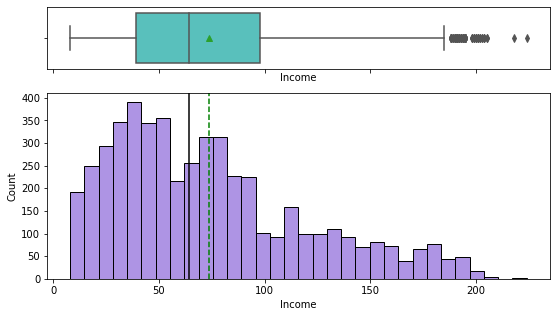

In [28]:
histogram_boxplot(data = df, feature = 'Income' )

- The income is right skewed with its median within the 60 range
- Some individuals earn more than the rest prompting outliers
- The is form of decline in income from the chart above, showing the more people earn between 40 and 100

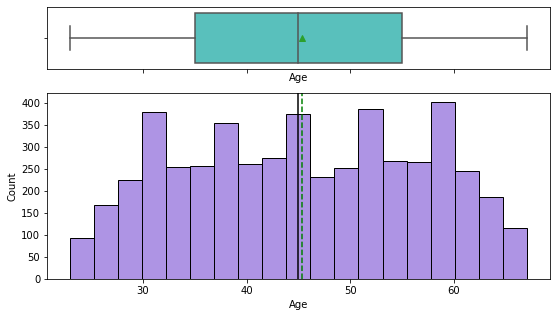

In [29]:
histogram_boxplot(data = df, feature = 'Age' )

- Age is normally distributed
- The median age is 45
- Age concentration from the chart is between 35 and 55

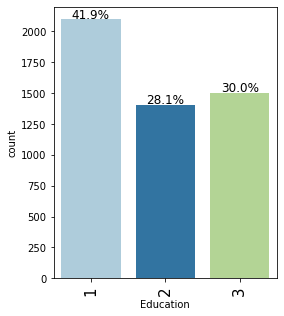

In [30]:
labeled_barplot(df, "Education", perc=True)

##### Observations
- 49% of the population have Level 1 Education(This can be termed as University or College)
- 28.1% of the population have Level 2 Education (Assume this to be Msc)
- 30.0% of the population have Level 3 Education (PhD and Post Doc degrees)
- This is a well educated society that can read and understand terms and conditions of Loans.

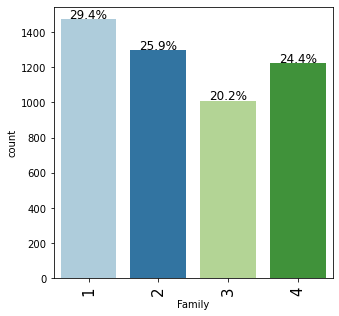

In [31]:
labeled_barplot(df, "Family", perc=True)

##### Observations
- 29.4% of the population have 1 child
- 25.9% of the population have 2 children
- 20.2% of the population have 3 children
- 24.4% of the population have 4 children
- Having family can increase one obligation due to unexpected need for cash

Text(0.5, 1.0, 'Family and Personal Loan Chart')

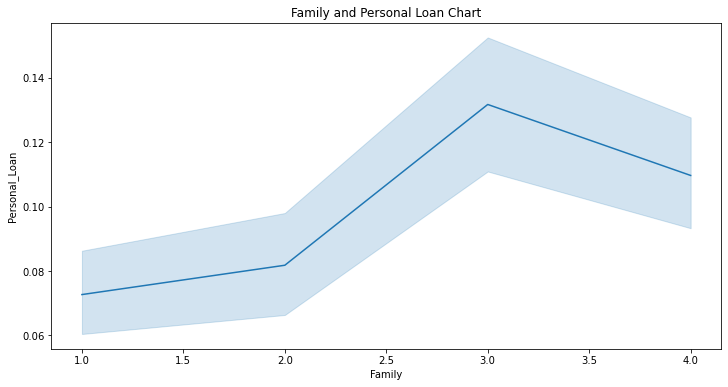

In [130]:
plt.figure(figsize=(12,6))
sns.lineplot(data= df, x= 'Family', y= 'Personal_Loan')
plt.title("Family and Personal Loan Chart")

- Their exist a linear relationship between family and personal loan as show in the chart above

In [33]:
columns = list(df)[:-1]

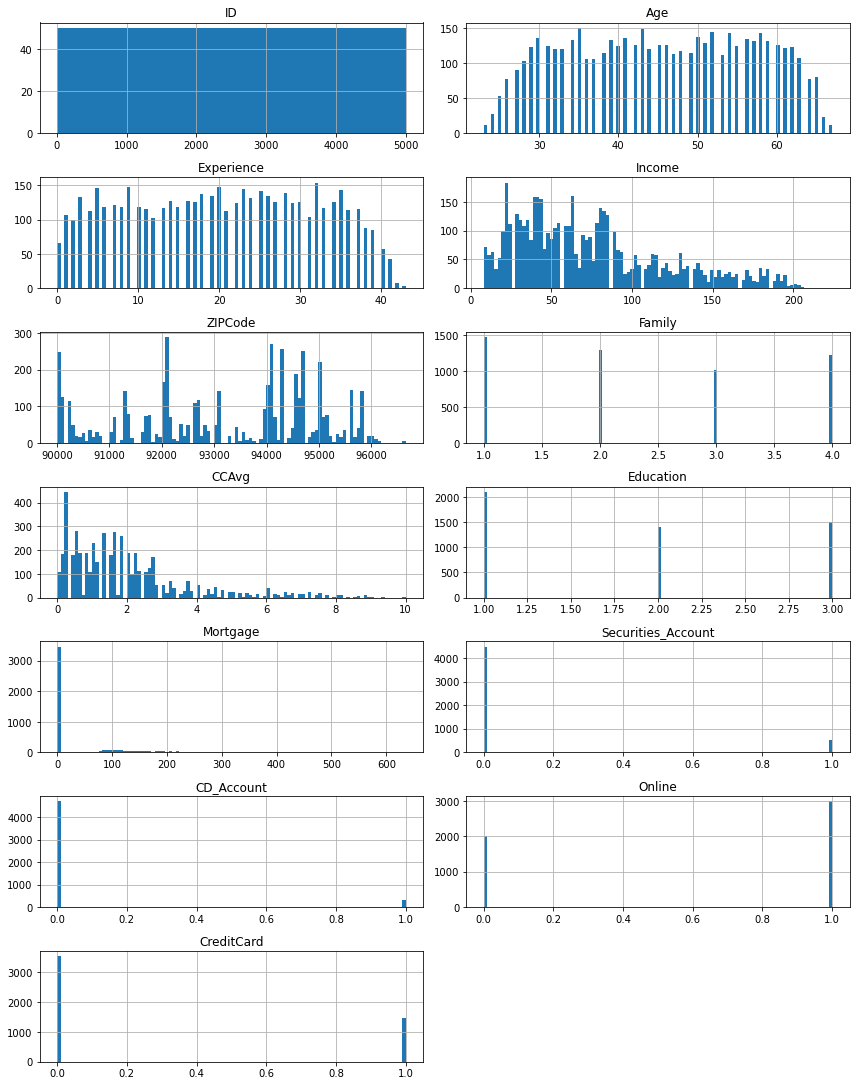

In [34]:
df[columns].hist(stacked = False, bins = 100, figsize=(12,30),
                  layout=(14,2));
plt.tight_layout()

- Age and Experience are normally distributted
- Income is right skewed
- Family and Education are in form of Categorical data based on its representation
- CCAvg is right skewed
- Securities_account,  CD_account, Online and Credit card are in form of class (0 and 1)

In [35]:
df = df.drop(['ID','ZIPCode'], axis =1) # dropping the ID and ZIPCode column

In [36]:
df.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard',
       'Personal_Loan'],
      dtype='object')

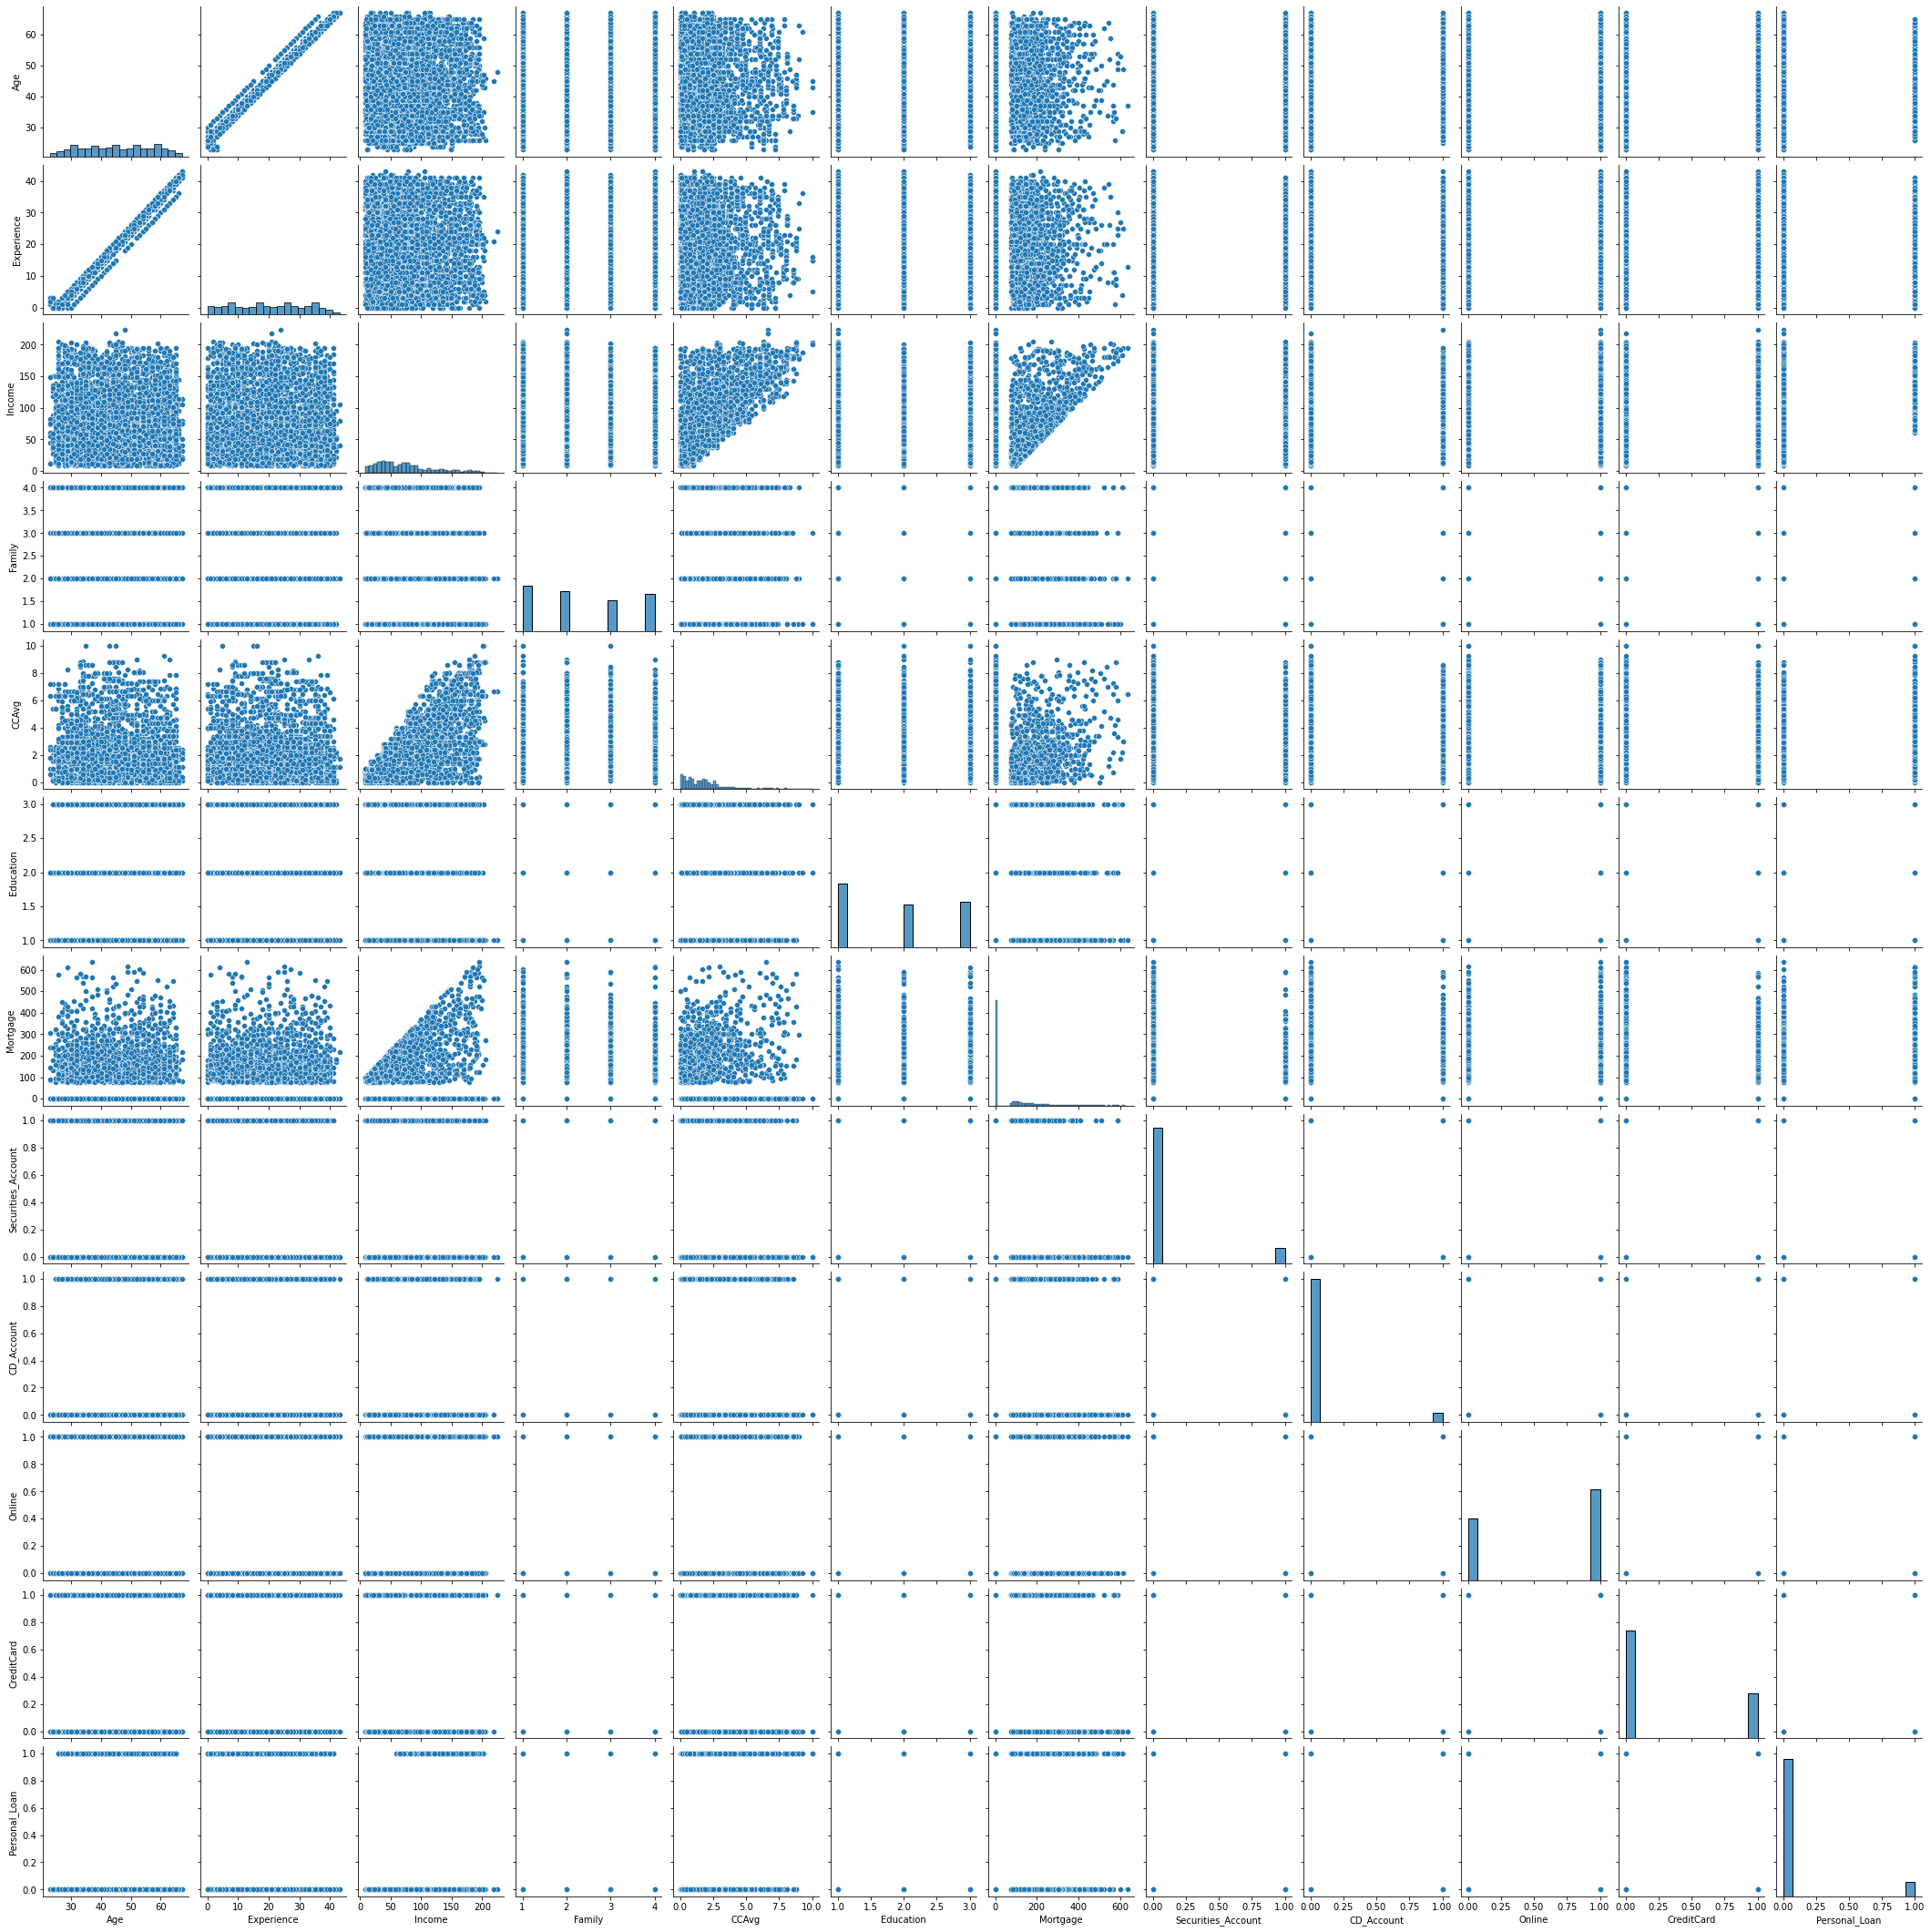

In [136]:
sns.pairplot(df) 

##### Observations
- Age and Experience have a linear relationship as shown above
- Mortgage is right skewed as shown above

In [37]:
df_num = df.select_dtypes(exclude ='object') # obtains the numerical data type
df_num = df_num.drop(['Family','Education'], axis = 1)

In [38]:
df_cat = df[['Family', 'Education']]

In [39]:
mat_corr = df_num.corr()

<AxesSubplot:>

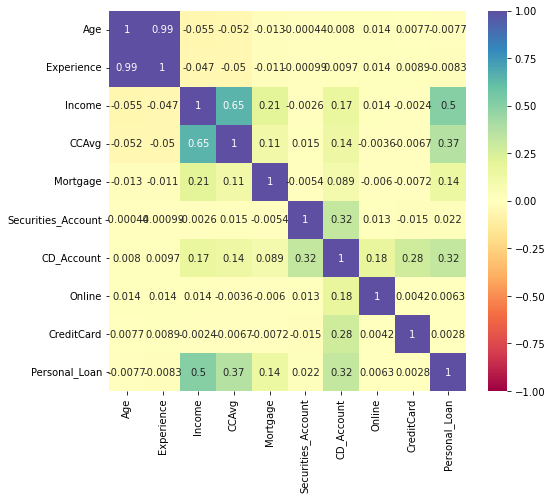

In [40]:
# plot a heatmap of the corr
plt.figure(figsize=(8,7))
sns.heatmap(mat_corr, annot=True, vmin = -1, vmax=1, cmap = 'Spectral')

##### Observations
- Income has the highest correlation to personal_loan as shown in the heatmap above
- CCAvg, CD_Account and mortgage have little correlation to personal_loan
- From the above heatmap, it can be said that Age, Experience, Online and CreditCard have little effect on Personal loan
- Based on the attributes of logistics regression, multi-collinearity have no effect on it.

##### Splitting the data to train, test and validation

In [41]:
X = df.drop('Personal_Loan', axis =1)
y = df['Personal_Loan']

In [42]:
# split into train, validation and test data

X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.2,
                                                           random_state= 0,
                                                           stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_v,
                                                 y_train_v,
                                                 test_size=0.2,
                                                 random_state=0,
                                                 stratify=y_train_v)
# stratify splits the data and maintain the proportion of both classes in classification

In [43]:
# check the shape
X_train_v.shape,y_train_v.shape, X_test.shape,  y_test.shape, X_val.shape, y_val.shape

((4000, 11), (4000,), (1000, 11), (1000,), (800, 11), (800,))

##### Functions that train and evaluate the models

In [44]:
# function to train a model and compute train accuracy

def train(model, X,y):
    """
    Function to train the model and compute accuracy
    
    model: Model algorithm not yet traineed
    X: train feaures
    y: train target
    """
    
    trained_model = model.fit(X,y)
    preds = trained_model.predict(X)
    acc = accuracy_score(y, preds)
    
    print(f'Trained Accuracy: {acc}')
    return trained_model


# function to evaluate the model and compute metrics on test data
def evaluate(model,X,y, threshold = 0.5): # the higher the thres the more strict u are, y can be validation or test data
    """
    function to evaluate our trained model with different metrics
    
    model: trained model(classifier)
    X: validation features
    y: target in validation data
    
    threshold: values to filter predictions
    """
    
    pred_proba = model.predict_proba(X)[:, 1] # it predicts two columns but we are interested in the 1class (True)
    pred_class = np.round(pred_proba > threshold) # convert to 0 or 1
    acc = accuracy_score(y, pred_class)
    recall = recall_score(y, pred_class)
    precision = precision_score(y, pred_class)
    f1 = f1_score(y, pred_class)
    
    df = pd.DataFrame({
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }, index =[0])
    
    conf = confusion_matrix(y, pred_class, labels=[0,1]) # confusion matrix
    disp = ConfusionMatrixDisplay(conf, display_labels=[0,1])
    disp.plot()
    plt.show()
    
    return df

##### define a function for ROC and AUC curves to get the best threshold

In [45]:
# define a function for ROC and AUC curves to get the best threshold
def droc_curve(model, X, y):
    """
    Function to create ROC Curve
    
    model: trained model
    X: test or validaton features
    y: target in the test data
    """
    preds = log_reg.predict_proba(X_test_sc)[:,1]
    auc = roc_auc_score(y_test, preds)
    fpr, tpr, thre = roc_curve(y_test,preds)

    plt.figure(figsize=(7,5))
    plt.plot(fpr,tpr,label = f'Logistic regression {auc:.2f}')

    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim(0.0,1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel ("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc = 'lower right')
    plt.show()
    
    return thre, tpr, fpr # threshold
# using the threshold to tweak the model

##### Balancing data Function

In [46]:
# balancing the original data before splitting, 
# only balance the training data to see if it will differentiate from new data
# define a function to balance the data

def balance_data(X,y, smote_type):
    """
    X: Train features
    y: Train target
    smote_type: Kind of imbalance strategy
    """
    
    X_res, y_res = smote_type.fit_resample(X,y) # generating artificial data
    return X_res, y_res

##### Normilization

In [47]:
# creating an instance of the Normalization
scaler = MinMaxScaler()

In [48]:
# scaling the data
X_train_v_sc = scaler.fit_transform(X_train_v)
X_test_sc = scaler.transform(X_test)

X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)

##### Building the model for logistic regression

In [49]:
# creating an instance with random state = 0
log_reg = LogisticRegression(random_state=0)

In [50]:
# check train accuracy
log_reg_model = train(log_reg,X_train_v_sc, y_train_v ) # model with training sample

Trained Accuracy: 0.95025


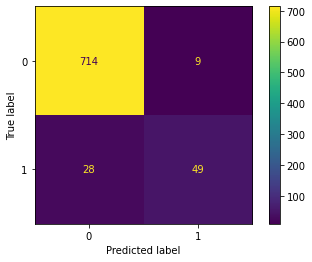

,Accuracy,Precision,Recall,F1
0,0.95375,0.844828,0.636364,0.725926


In [51]:
eva_log =evaluate(log_reg_model, X_val_sc, y_val) # evaluation of the model
eva_log

#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 28 have no the personal loan product and correctly predicted 49 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 9 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 84% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 63% correctly

The aim is to build a model that can predict the number of customers that have personal loan


#### Model Improvement
- Metrics
- Here we are considering a situation where the TP rates are far from the FP rates

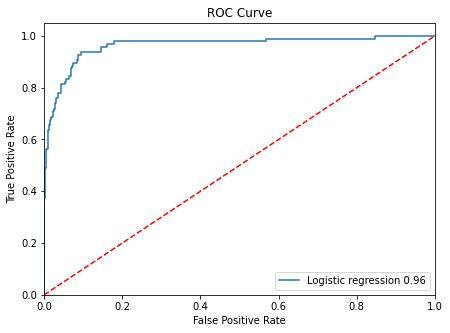

In [52]:
thre, tpr, fpr= droc_curve(log_reg_model, X_test_sc, y_test)

In [53]:
optimal_idx = np.argmax(tpr-fpr) # we need the position of the maximum different we use argmax

print (f' The threshold is at {optimal_idx}')

 The threshold is at 58


In [54]:
optimal_thre = thre[optimal_idx]
optimal_thre

0.12257989382206927

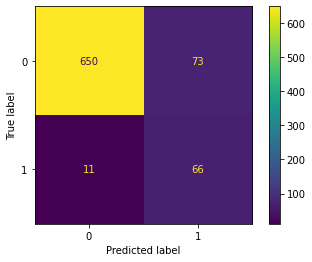

,Accuracy,Precision,Recall,F1
0,0.895,0.47482,0.857143,0.611111


In [55]:
eva_log =evaluate(log_reg_model, X_val_sc, y_val,  threshold= optimal_thre) # evaluation of the model
eva_log

#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 11 have no the personal loan product and correctly predicted 66 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 73 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 47% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 85% correctly

#### Model Improvement
- Model Hyperparameters

- Here we rebuild the model when we get the optimal accuracy

In [56]:
c_values = np.random.rand(5,2).flatten()# the default value of c is 1, 

accs = []
for c in c_values:
    model = LogisticRegression(C=c)
    model.fit(X_train_v_sc, y_train_v)
    acc = model.score(X_val_sc, y_val)
    accs.append(acc)

In [57]:
optimal_idx = np.argmax(accs)

optimal_c = c_values[optimal_idx]

print(f' The optimal value of C = {optimal_c}')

 The optimal value of C = 0.7973351619405085


Trained Accuracy: 0.95


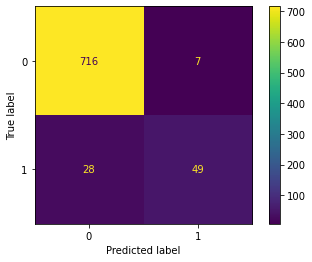

,Accuracy,Precision,Recall,F1
0,0.95625,0.875,0.636364,0.736842


In [58]:
log_reg_c = LogisticRegression(random_state=0, C = optimal_c)

# calling the training function and evaluate function

log_reg_c_model = train(log_reg_c, X_train_v_sc, y_train_v) 

df_c = evaluate(log_reg_c_model, X_val_sc, y_val)
df_c

#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 28 have no the personal loan product and correctly predicted 49 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 7 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 88% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 63% correctly



#### Model Improvement
- From Data aspect

- Here we rebuild the model when we get the optimal accuracy

In [59]:
# creating an instance of all the imblearn methods

under = RandomUnderSampler(random_state=0)
over = RandomOverSampler(random_state=0)
smote = SMOTE(random_state=0)
adasyn = ADASYN(random_state=0)

In [60]:
# implementing balancing

X_train_un,y_train_un = balance_data(X_train_v_sc, y_train_v, under)
X_train_ov,y_train_ov = balance_data(X_train_v_sc, y_train_v, over)
X_train_sm,y_train_sm = balance_data(X_train_v_sc, y_train_v, smote)
X_train_ad,y_train_ad = balance_data(X_train_v_sc, y_train_v, adasyn)

In [61]:
# to count the data target

from collections import Counter

Counter(y_train_un) # now the classes are the same

Counter({0: 384, 1: 384})

##### Under Sampling

Trained Accuracy: 0.8984375


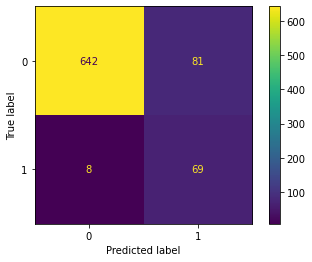

,Accuracy,Precision,Recall,F1
0,0.88875,0.46,0.896104,0.60793


In [62]:
log_reg_un = train(log_reg,X_train_un,y_train_un)# using the default paramenter

df_un = evaluate(log_reg_un, X_val_sc,y_val) # we maintain the imbalance on the test data

df_un


#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 8 have no the personal loan product and correctly predicted 69 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 81 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 46% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 89% correctly



##### Over-Sampling

In [63]:
Counter(y_train_ov)

Counter({0: 3616, 1: 3616})

Trained Accuracy: 0.894358407079646


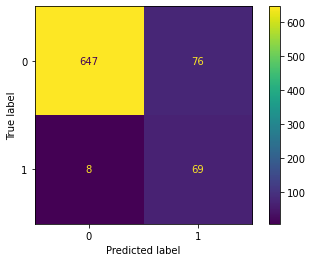

,Accuracy,Precision,Recall,F1
0,0.895,0.475862,0.896104,0.621622


In [64]:
log_reg_ov = train(log_reg,X_train_ov,y_train_ov)# using the default paramenter

df_ov = evaluate(log_reg_ov, X_val_sc,y_val) # we maintain the imbalance on the test data

df_ov


#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 8 have no the personal loan product and correctly predicted 69 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 76 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 47% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 89% correctly

##### SMOTE

In [65]:
Counter(y_train_sm)

Counter({0: 3616, 1: 3616})

Trained Accuracy: 0.9054203539823009


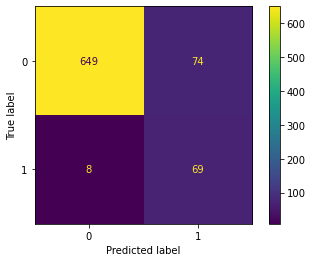

,Accuracy,Precision,Recall,F1
0,0.8975,0.482517,0.896104,0.627273


In [66]:
log_reg_sm = train(log_reg,X_train_sm,y_train_sm)# using the default paramenter

df_sm = evaluate(log_reg_sm, X_val_sc,y_val)

df_sm

#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 8 have no the personal loan product and correctly predicted 69 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 74 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 48% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 89% correctly

##### ADASYN

In [67]:
Counter(y_train_ad)

Counter({0: 3616, 1: 3600})

Trained Accuracy: 0.8822062084257206


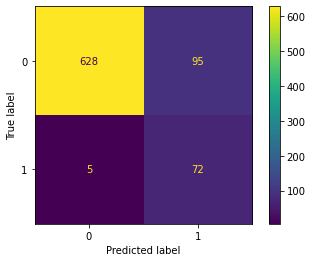

,Accuracy,Precision,Recall,F1
0,0.875,0.431138,0.935065,0.590164


In [68]:
log_reg_ad = train(log_reg,X_train_ad,y_train_ad)# using the default paramenter

df_ad = evaluate(log_reg_ad, X_val_sc,y_val)

df_ad

#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 5 have no the personal loan product and correctly predicted 72 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 95 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 43% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 93% correctly

#### Model Recommendation for Logistic Regression
- The ADASYN model improves more on the recall metrics, we need to successfully predict the target market (individuals with personal loan) this will aid the improvement of the market campaign to see the attributes of people.

##### On the test data

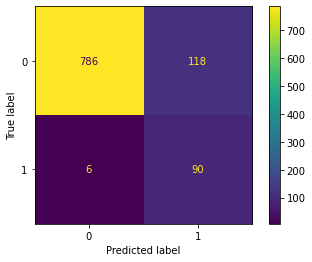

,Accuracy,Precision,Recall,F1
0,0.876,0.432692,0.9375,0.592105


In [110]:
df_ad = evaluate(log_reg_ad, X_test_sc,y_test)

df_ad

##### DECISION TREE MODEL

In [69]:
# instantiation the decision tree model
dtree = DecisionTreeClassifier(random_state=0) # default

In [70]:
dtree_model = train(dtree, X_train_v_sc, y_train_v) 

Trained Accuracy: 1.0


- The above result shows overfitting of the model

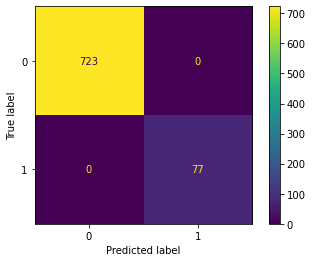

,Accuracy,Precision,Recall,F1
0,1.0,1.0,1.0,1.0


In [71]:
dtree_df = evaluate(dtree, X_val_sc, y_val)
dtree_df 

- The above result implies a perfectly overfit model, to rectiy this issue, the trees will be pruned

##### Plotting the tree

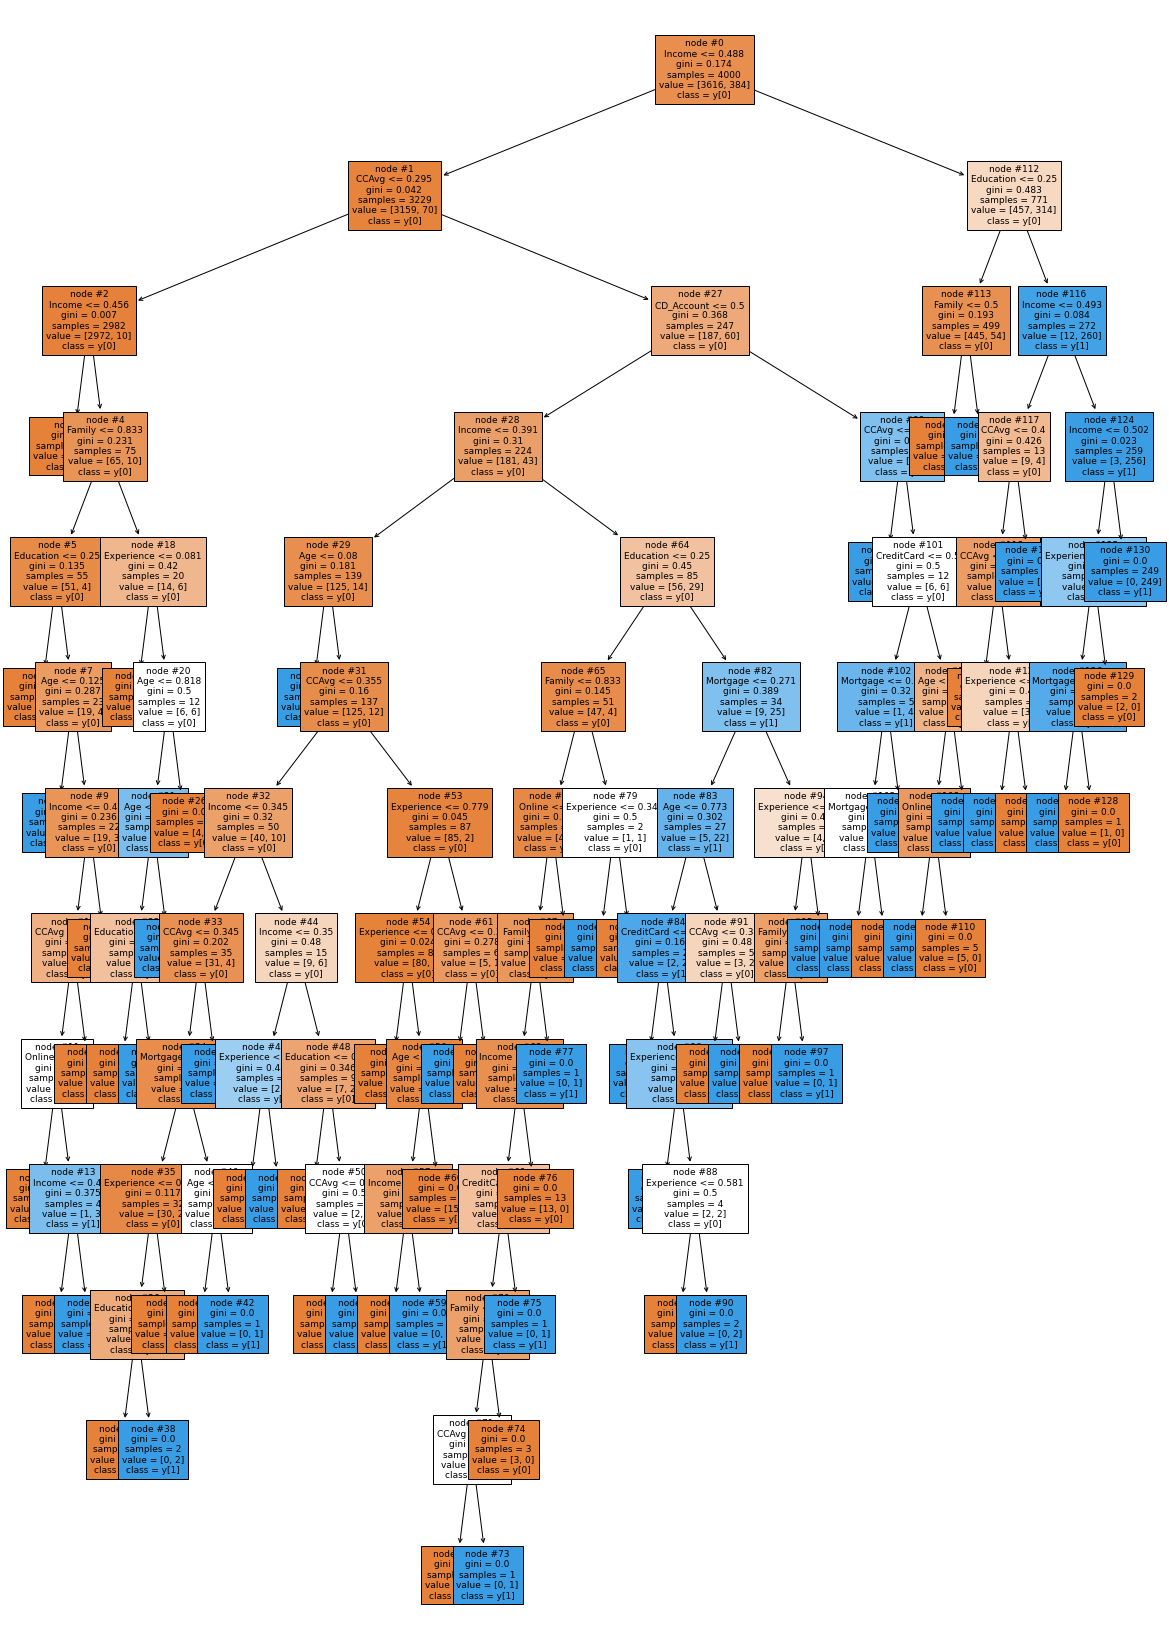

In [72]:
feat_names = list(X.columns)
def plot_dtree(dtree):
    plt.figure(figsize=(20,30))
    

    tree.plot_tree(dtree, feature_names=feat_names, class_names= True,
                  filled = True, node_ids=True, fontsize=9) # class name focuses on the low distribution feature
    plt.show()

plot_dtree(dtree_model)

- From the decision tree above, the model exhibits perfect nodes for the two classes under review.

#### Model Improvement
- class weight with pre-pruning
- Pre-pruning  decision tree Using Max-depth

##### setting smaller weight to the majority class and higher weight to the minority class if your target is the minority class the above is needed

In [77]:
dtree2 = DecisionTreeClassifier(random_state=0, class_weight={0:0.1,1:0.9},
                               max_depth= 4) 
dtree2_model = train(dtree2, X_train_v, y_train_v)

Trained Accuracy: 0.9665


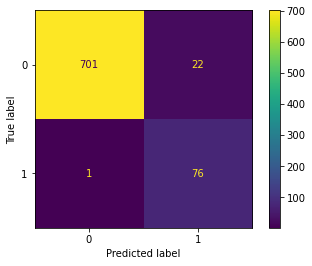

,Accuracy,Precision,Recall,F1
0,0.97125,0.77551,0.987013,0.868571


In [80]:
dtree2_df = evaluate(dtree2, X_val, y_val)

dtree2_df

#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 1 have no the personal loan product and correctly predicted 76 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 22 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 77% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 98% correctly

The performance of the model improved as shown from the Recall and F1 score. 

##### On the Test data

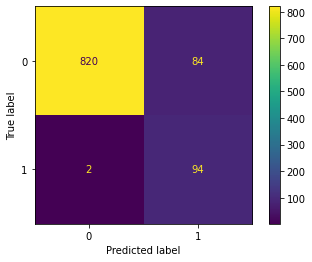

,Accuracy,Precision,Recall,F1
0,0.914,0.52809,0.979167,0.686131


In [82]:
### Adding threshold to reduce the mistake, if we increase the threshold we are now embedding the precision

test = evaluate(dtree2_model, X_test, y_test, threshold=0.2)
test

#### From the confusion matrix

- Out of 96 customers, the model incorrectly predicted that 2 have no the personal loan product and correctly predicted 94 have a personal loan

- There are 904 who have no the personal loan product the model incorrectly predicted that 84 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 52% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 97% correctly

##### Feature Importance

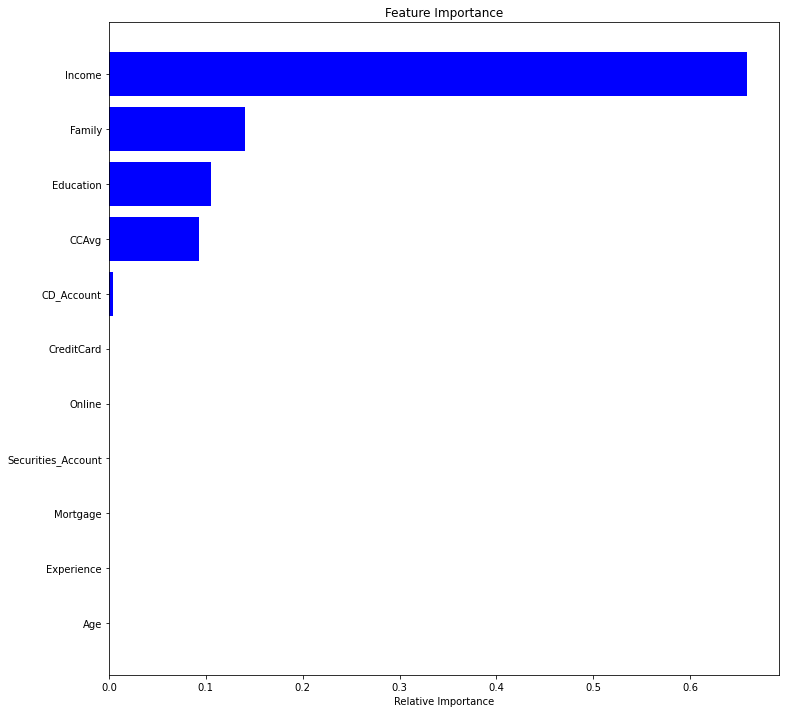

In [83]:
    
importances = dtree2_model.feature_importances_ # important features

def plot_importance(importances):
    indices = np.argsort(importances) # gives us the index of the importance from smallest to biggest

    plt.figure(figsize = (12,12))
    plt.title("Feature Importance")
    plt.barh(range(len(indices)), importances[indices], color = 'blue',
            align='center')
    plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
    plt.xlabel("Relative Importance")
    plt.show()
    
plot_importance(importances)

##### Observations

- From the Feature importance chart, in the order of importance I observed that the below have more effect on the personal loan:
    - Income
    - Family
    - Education
    - Average credit card usage CCAVG.
    - Certificate of Deposit
    - CreditCard
    - Online
    - Securities_account
    - Mortgage
    - Experience
    - Age

##### Random Forest Model

In [85]:
# creating an instance of the model
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

In [86]:
# train the model
rf_model = train(rf,X_train_v_sc, y_train_v)

# performance score
rf_model

Trained Accuracy: 1.0


RandomForestClassifier(n_jobs=-1, random_state=0)

- From the above accuracy I observed that it overfits by having an accuracy score of 100%
- This can be modified by introducing class weight and max_depth hyper-parameters

##### Modify and pruning

In [87]:
rf2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4,
                           class_weight={0:0.15, 1:0.90})

In [88]:
# train the model
rf_model2 = train(rf2,X_train_v_sc, y_train_v)

# performance score
rf_model2

Trained Accuracy: 0.97625


RandomForestClassifier(class_weight={0: 0.15, 1: 0.9}, max_depth=4, n_jobs=-1,
                       random_state=0)

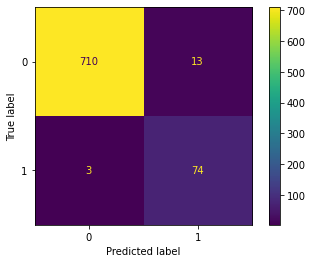

,Accuracy,Precision,Recall,F1
0,0.98,0.850575,0.961039,0.902439


In [90]:
# evaluate
rd_df = evaluate(rf_model2, X_val_sc, y_val)
rd_df

#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 3 have no the personal loan product and correctly predicted 74 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 13 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 85% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 96% correctly

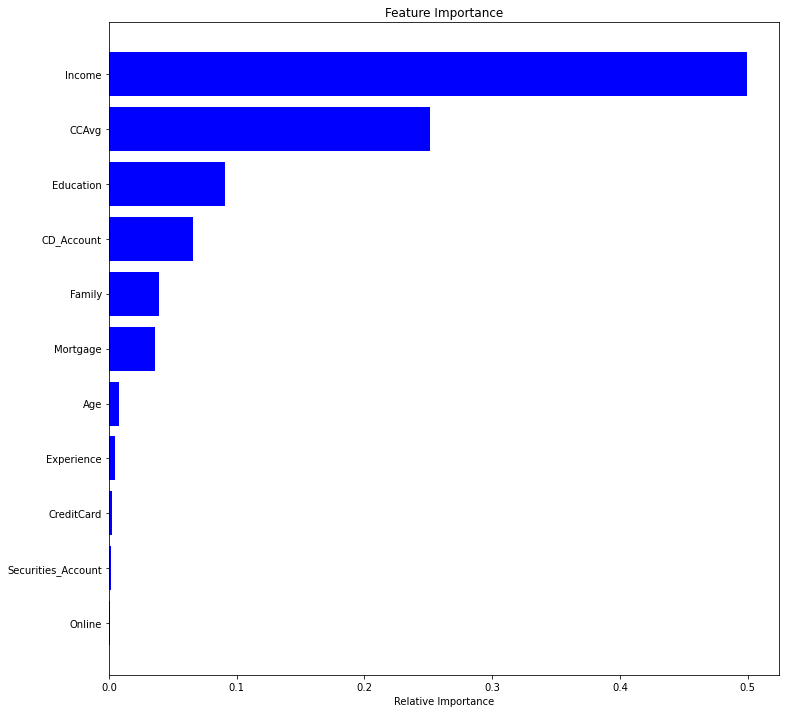

In [91]:
rf_imp = rf_model2.feature_importances_ # important features

plot_importance(rf_imp)

##### Observations

- From the Random Forest Feature importance chart, in the order of importance I observed that the below have more effect on the personal loan:
    - Income
    - Average credit card usage CCAVG.
    - Education
    - Certificate of Deposit
    - Family
    - Mortgage
    - Age
    - Experience
    - CreditCard
    - Securities_Account
    - Online

##### On the Test Data 

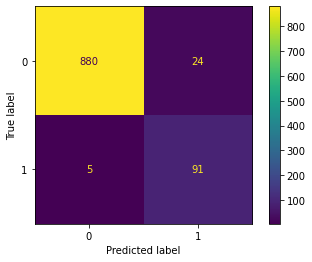

,Accuracy,Precision,Recall,F1
0,0.971,0.791304,0.947917,0.862559


In [109]:
# evaluate
rd_df = evaluate(rf_model2, X_test_sc, y_test)
rd_df

##### Gradient Boosting

In [92]:
# instantiate the classifier
gb = GradientBoostingClassifier(random_state=0)

# train the model
gb_model = train(gb, X_train_v_sc, y_train_v)


Trained Accuracy: 0.9955


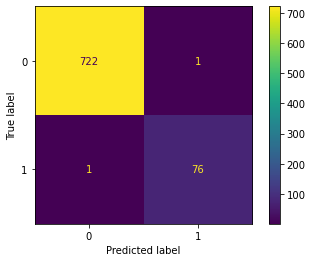

,Accuracy,Precision,Recall,F1
0,0.9975,0.987013,0.987013,0.987013


In [93]:
# performance scores
gb_df = evaluate(gb_model, X_val_sc, y_val)
gb_df 

#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 1 have no the personal loan product and correctly predicted 76 have a personal loan

- There are 723 who have no the personal loan product the model incorrectly predicted that 1 of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 98% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 98% correctly

In [95]:
# set the parameters to tune
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1, 10],
             'max_depth': [1, 2, 3, 4]}

# instantiate the models

grid = GridSearchCV(gb, param_grid, cv = 5, n_jobs = -1, scoring = "recall")


# fit the grid search model on the training set
grid.fit(X_train_v, y_train_v)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'max_depth': [1, 2, 3, 4]},
             scoring='recall')

In [99]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 4}

In [100]:
grid.best_score_

0.9140806561859194

In [101]:
best_params = grid.best_params_

In [102]:
# rebuilding the gb

gb_imp = GradientBoostingClassifier(**best_params, random_state=0) 
# ** means pass the whole of best params inside as a dictionary

gb_imp_model = train(gb_imp,X_train_v, y_train_v)

Trained Accuracy: 0.999


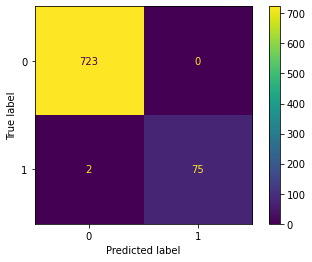

,Accuracy,Precision,Recall,F1
0,0.9975,1.0,0.974026,0.986842


In [104]:
gb_imp_df = evaluate(gb_imp_model,X_val, y_val)

gb_imp_df

#### From the confusion matrix

- Out of 77 customers, the model incorrectly predicted that 2 have no the personal loan product and correctly predicted 75 have a personal loan

- There are 723 who have no the personal loan product the model correctly predicted the classes 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 100% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 98% correctly

##### On the Test Data

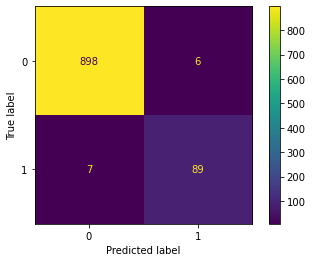

,Accuracy,Precision,Recall,F1
0,0.987,0.936842,0.927083,0.931937


In [106]:
gb_imp_df = evaluate(gb_imp_model,X_test, y_test)

gb_imp_df

#### From the confusion matrix

- Out of 96 customers, the model incorrectly predicted that 7 have no the personal loan product and correctly predicted 89 have a personal loan

- There are 904 who have no the personal loan product the model incorrectly predicted that 6 out of them have personal loan 

- Precision: Out of the number of people the model predicted to have personal loan product the model predicted 93% correctly

- Recall: Out of all the people in the data that have personal loan product the model predicted only 92% correctly

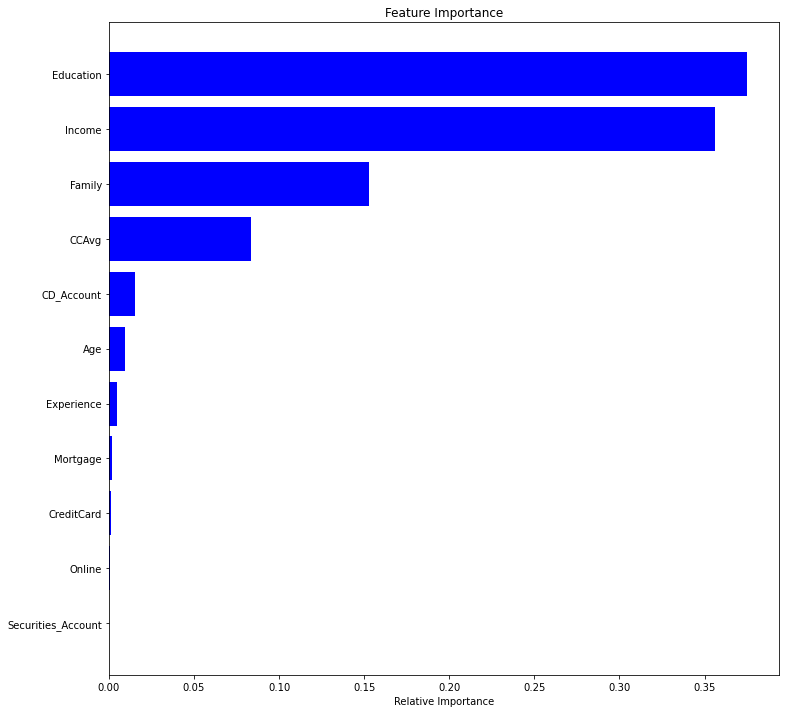

In [126]:
gb_impo = gb_imp_model.feature_importances_ # important features

plot_importance(gb_impo)

##### Observations
- From the Gradient Boosting Feature Importance in the order of importance, I observed the the below are of importance in the order of most importance to least importance.

    - Education
    - Income
    - Family
    - CCAvg
    - CD_Account
    - Age
    - Experience
    - Mortgage
    - CreditCard
    - Online
    - Securities_Account

##### CONCLUSION

From the models presented, it can be observed that the model improves with the usage of tree based models and upon pruning I was able to achieve the first objective of building predictive models for customers that will take the product.

- The improved decision tree model produced the below result

    Accuracy	Precision	Recall	     F1
    
    0.97125	    0.77551	    0.987013	0.868571
    
    
- The gradient descent produced very excellent predictive and classification result, but my issue with this model is that it looks too good and seems to have overfit.
- The negative values of Experience in the data were converted to positve. I assumed this to be input error, given the age, family and income of the individuals that fell in this category

##### RECOMMENDATION

Loans are described as asset for any financial institution and it brings more revenue to the business more than any other product sold by the financial institution, to successfully harness information from the customer base and segment them different model was built and I recommend the use of the dtree2_model This is because it perfectly captured the classes in the task with my main focus on the recall metrics.

- My reason is because the recall captures the number of True Positives to the total number of True positives and False Negative. 

- To increase revenue the company should focus on the target market and can come up with products suitable for customer's that did not meet the criteria of Personal Loan.